# Download All J League Matches Starting in 1993
### (1993 is when the J League started)

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
from pathlib import Path

def _get_table(soup):
    return soup.find_all('table')[0]

def _get_opp_table(soup):
    return soup.find_all('table')[1]

def _parse_row(row):
    cols = None
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    return cols

def get_df(path):
    URL = path
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    table = _get_table(soup)
    data = []
    headings=[]
    headtext = soup.find_all("th",scope="col")
    for i in range(len(headtext)):
        heading = headtext[i].get_text()
        headings.append(heading)
    headings=headings[1:len(headings)]
    data.append(headings)
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')

    for row_index in range(len(rows)):
        row = rows[row_index]
        cols = _parse_row(row)
        data.append(cols)
    
    data = pd.DataFrame(data)
    data = data.rename(columns=data.iloc[0])
    data = data.reindex(data.index.drop(0))
    data = data.replace('',0)
    return data

cols = ['Year', 'Tournament', 'Section', 'Date', 'K/O Time', 'Home', 'Score', 'Away', 'Stadium', 'Attendance', 'Broadcast']
df = pd.DataFrame(columns=cols)


In [2]:
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, ]

cols = ['Year', 'Tournament', 'Section', 'Date', 'K/O Time', 'Home', 'Score', 'Away', 'Stadium', 'Attendance', 'Broadcast']
df = pd.DataFrame(columns=cols)

for i in range(len(years)):
    print(years[i])
    lgpath = 'https://data.j-league.or.jp/SFMS01/search?competition_years=%i&competition_frame_ids=1&competition_frame_ids=2&competition_frame_ids=3&tv_relay_station_name=' %years[i]
    df1 = get_df(lgpath)
    df1.columns = cols
    df = df.append(df1)
df


1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


,Year,Tournament,Section,Date,K/O Time,Home,Score,Away,Stadium,Attendance,Broadcast
1,1993,Ｊ１ サントリー,第１節第１日,05/15(土),19:29,Ｖ川崎,1-2,横浜M,国立,"59,626",0
2,1993,Ｊ１ サントリー,第１節第２日,05/16(日),13:05,横浜Ｆ,3-2,清水,三ツ沢,"14,126",0
3,1993,Ｊ１ サントリー,第１節第２日,05/16(日),13:59,広島,2-1,市原,広島ス,"11,875",0
4,1993,Ｊ１ サントリー,第１節第２日,05/16(日),16:00,鹿島,5-0,名古屋,カシマ,"10,898",0
5,1993,Ｊ１ サントリー,第１節第２日,05/16(日),19:04,Ｇ大阪,1-0,浦和,万博,"19,580",0
...,...,...,...,...,...,...,...,...,...,...,...
1070,2022,Ｊ３,第３４節第１日,11/20(日),14:03,長野,0-0,藤枝,長野Ｕ,"3,649",ＤＡＺＮ
1071,2022,Ｊ３,第３４節第１日,11/20(日),14:03,いわき,1-1,YS横浜,Ｊスタ,"3,018",ＤＡＺＮ／福島中央テレビ（録）
1072,2022,Ｊ３,第３４節第１日,11/20(日),14:03,沼津,1-2,宮崎,愛鷹,"2,366",ＤＡＺＮ
1073,2022,Ｊ３,第３４節第１日,11/20(日),14:03,松本,1-0,相模原,サンアル,"8,274",ＤＡＺＮ


In [3]:
dfx = df.reset_index(drop=True)
dfx.to_csv('J Leagues from 1993 xx.csv', encoding='utf-8-sig')

## After this stage, I have to go in and manually change a few things. Let me know if you want me to share that. Basically, it's changing all the names from their Japanese names to English (also involves handling name changes for teams across years), cleaning up the Competitions column (Japanese -> English and making it all J1, J2, or J3), making the Date column a usable mm/dd/yyyy format, and then splitting the scoreline to two columns, one for home and one for away

# Calculate and Create ELO Rankings

In [4]:
##### https://en.wikipedia.org/wiki/World_Football_Elo_Ratings

## Basic equation:
# Rn = Ro + P

# P = K*G*(W - We)

# Rn = The new team rating
# Ro = The old team rating
# K = Weight index regarding the tournament of the match
# G = A number from the index of goal differences
# W = The result of the match
# We = The expected result
# P = Points Change

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# df = pd.read_csv('J Leagues from 1993.csv') # this is the cleaned dataset, using what I said to do above
df = pd.read_csv('https://raw.githubusercontent.com/griffisben/misc-code/main/J%20Leagues%20from%201993.csv') # I uploaded the cleaned csv for you anyway!
df.dropna(subset=['HG'])

df['home_rating'] = 0
df['away_rating'] = 0

teams = list(df.Home.unique()) + list(df.Away.unique())
teams = list(set(teams))

start_elo = 1000
d = {'Team': teams}
team_elo = pd.DataFrame(d)
team_elo['elo'] = start_elo

for i in range(len(teams)):
    try:
        index = df[df.Home.str.contains(teams[i])].index[0]
    except:
        index = df[df.Away.str.contains(teams[i])].index[0]
    comp = df.Tournament[index]
    
    ### This next section here says, if the team first appears in J1, start them at ELO=1000
    ### If the team first appears in J2, then assign them 800 if they were promoted from J3 or 900 if they were in the second division when J2 was created
    ### If the team first appears in J3, same stuff as J2's start value but with 600 and 700

    if comp == 'J1':
        team_elo.at[team_elo.index[team_elo['Team']==teams[i]].values[0],'elo'] = 1000
    if comp == 'J2':
        if index > 1672:
            team_elo.at[team_elo.index[team_elo['Team']==teams[i]].values[0],'elo'] = 800
        else:
            team_elo.at[team_elo.index[team_elo['Team']==teams[i]].values[0],'elo'] = 900
    if comp == 'J3':
        if index > 10681:
            team_elo.at[team_elo.index[team_elo['Team']==teams[i]].values[0],'elo'] = 600
        else:
            team_elo.at[team_elo.index[team_elo['Team']==teams[i]].values[0],'elo'] = 700

c = {'Team':[],
     'Date':[],
    'elo':[]}
elo_timeseries = pd.DataFrame(c)


for i in range(len(df)):
    home_team = df.Home[i]
    away_team = df.Away[i]
    date = df.Date[i]

    home_rating = team_elo.at[team_elo.index[team_elo['Team']==home_team].values[0],'elo']
    away_rating = team_elo.at[team_elo.index[team_elo['Team']==away_team].values[0],'elo']
    

    HG = df.HG[i]
    AG = df.AG[i]
    GD = HG-AG



    # K = Weight index regarding the tournament of the match (30 for 'all other matches', 20 friendlies, 40 is EC/EU qualifiers)
    K = 20

    # G = A number from the index of goal differences
    if 0 <= abs(GD) <= 1:
        G = 1
    if abs(GD) == 2:
        G = 3/2
    if abs(GD) >= 3:
        G = (11+GD)/8

    # W = The result of the match
    if GD < 0:
        W = 0
    if GD == 0:
        W = 0.5
    if GD > 0:
        W = 1

    # dr is the difference of the teams' scores
    dr = (home_rating + 68) - away_rating

    # We = The expected result
    We = 1/(10**(-dr/400)+1)

    # P = Points Change
    P = K*G*(W - We)

    # Rn = The new team rating
    team_elo.at[team_elo.index[team_elo['Team']==home_team].values[0],'elo'] += P
    team_elo.at[team_elo.index[team_elo['Team']==away_team].values[0],'elo'] += -P
    
    new_home = home_rating + P
    new_away = away_rating - P
    
    df['home_rating'][i] = new_home
    df['away_rating'][i] = new_away
    
    new_home_row = {'Team': home_team,
               'Date': date,
               'elo': new_home}
    new_away_row = {'Team': away_team,
               'Date': date,
               'elo': new_away}
    
    elo_timeseries = elo_timeseries.append(new_home_row,ignore_index=True)
    elo_timeseries = elo_timeseries.append(new_away_row,ignore_index=True)
    

team_elo.sort_values(['elo'], ascending=False, inplace=True)
team_elo = team_elo.reset_index(drop=True)

# comp_look = pd.read_csv('J Leagues from 1993.csv') # Again, the cleaned csv
comp_look = pd.read_csv('https://raw.githubusercontent.com/griffisben/misc-code/main/J%20Leagues%20from%201993.csv') # I uploaded the cleaned csv for you anyway!
elo_timeseries['Current League']=''
for i in range(len(elo_timeseries)):
    try:
        elo_timeseries['Current League'][i] = comp_look[comp_look['Away']==elo_timeseries.Team[i]].Tournament.tolist()[-1]
    except:
        elo_timeseries['Current League'][i] = comp_look[comp_look['Home']==elo_timeseries.Team[i]].Tournament.tolist()[-1]

print('Done')

elo_timeseries.to_csv('ELO Japan from 1993.csv')



C:\Users\Ben\AppData\Local\Temp/ipykernel_16468/605845993.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['home_rating'][i] = new_home
C:\Users\Ben\AppData\Local\Temp/ipykernel_16468/605845993.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['away_rating'][i] = new_away
C:\Users\Ben\AppData\Local\Temp/ipykernel_16468/605845993.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elo_timeseries['Current League'][i] = co

Done


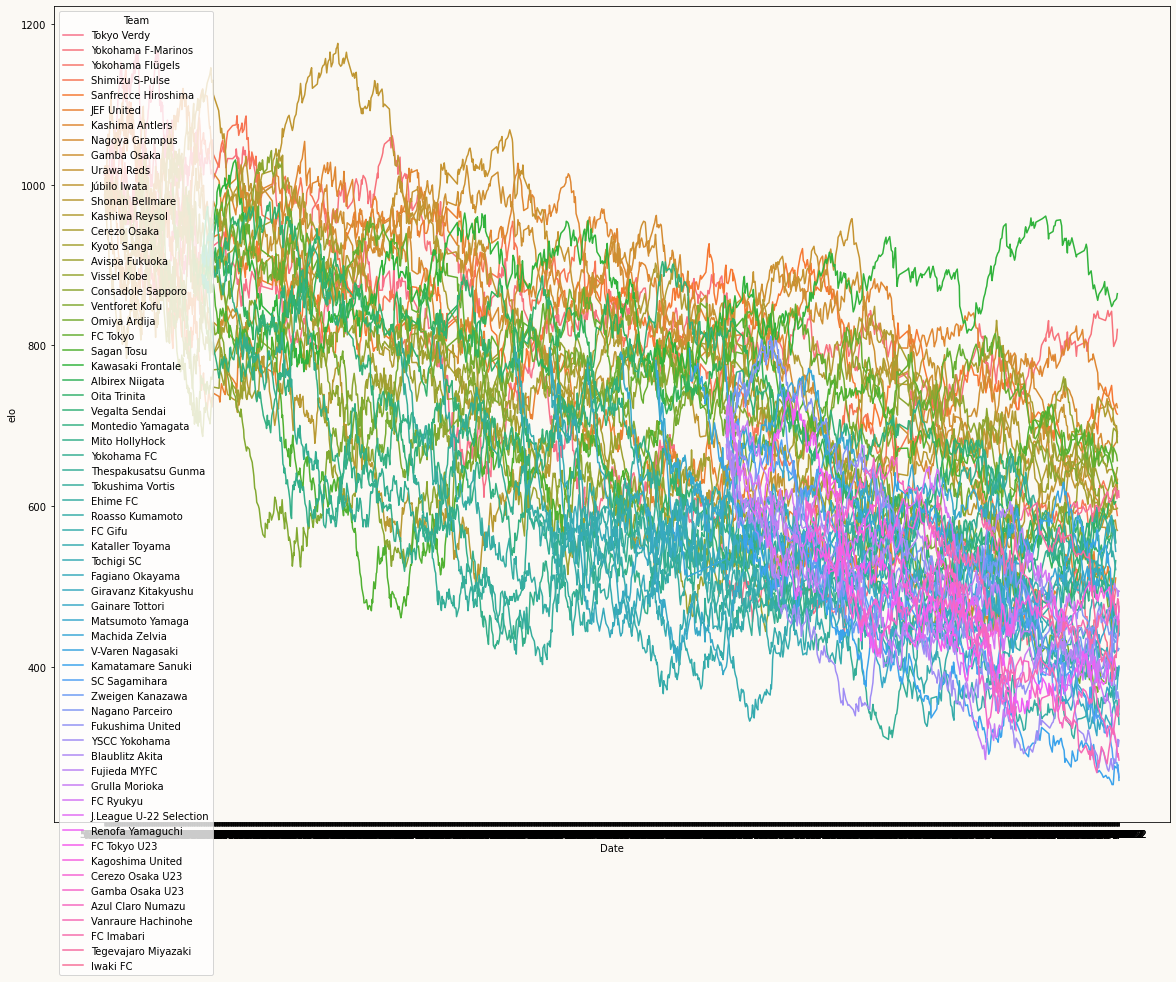

In [6]:
# I just visualize it really quick to make sure it all worked!

df = pd.read_csv('ELO Japan from 1993.csv')

ax = sns.lineplot(data=df, x='Date', y='elo', hue='Team')

ax.set_facecolor('#fbf9f4')

fig = plt.gcf()
fig.set_size_inches(20, 15)

fig.patch.set_facecolor('#fbf9f4')



In [7]:
elo_timeseries

,Team,Date,elo,Current League
0,Tokyo Verdy,5/15/1993,988.067417,J2
1,Yokohama F-Marinos,5/15/1993,1011.932583,J1
2,Yokohama Flügels,5/16/1993,1008.067417,J1
3,Shimizu S-Pulse,5/16/1993,991.932583,J1
4,Sanfrecce Hiroshima,5/16/1993,1008.067417,J1
...,...,...,...,...
39823,Tegevajaro Miyazaki,11/20/2022,456.466018,J3
39824,Matsumoto Yamaga,11/20/2022,441.033705,J3
39825,SC Sagamihara,11/20/2022,261.966295,J3
39826,Gainare Tottori,11/20/2022,400.668975,J3
